# Project Report 

## Introduction 

My goal for this project was to investigate student loan default rate for post-secondary institutions in the United States. The student loan default rate, also known as cohort default rate, represents the percentage of students at a given college who default on their federal student loans within three years. High student loan default rate can lead to potential issues down the road for students, colleges, and taxpayers alike. In particular, when a college has more than 25% for its student loan default rate, it faces federal sanctions that could make them ineligible from participating in the federal student loan program. 

What I did: 
- Estimated the cumulative distribution of cohort default rate by institution types 
    - Determined the probability of institutions having cohort default rate greater than 30% given institution type 
- Estimated the cumulative distribution of cohort default rate for all institutions, compared the distribution to Gaussian, and used two different types of 95% confidence intervals to estimate the mean cohort default rate
- Used multiple testing (Wald test and Bonferroni Method) to determine whether there are significant differences in the average cohort default rate between different types of institutions
- Explored factors associated with cohort default rate and built a model for cohort default rate as a function of selected variables 

## Data Sources & Preparation 

College Scorecard is an online tool created by the United States Department of Education to provide reliable data on higher education's college costs, student graduation,student debt, post-college earnings, and more. 

From College Scorecard, I downloaded the most recent data published in September 2017. This dataset provides 1777 attributes of 7593 post-secondary institutions. The institutions in the dataset include schools within the United States and outside of United States. For the purpose of this investigation, I decided to only look at 4-year post-secondary institutions in the contiguous United States (N = 2197). Furthermore, I decided to ignore any missing values. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Fetch data using CURL 
!curl 'https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-All-Data-Elements.csv' -o Most-Recent-Cohorts-All-Data-Elements.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  140M  100  140M    0     0  7195k      0  0:00:20  0:00:20 --:--:-- 6871k


### Read csv file containing most recent cohort default rates 

In [3]:

df = pd.read_csv('Most-Recent-Cohorts-All-Data-Elements.csv', low_memory=False)

# Because we are interested only in the institutions within the 50 states of US, we drop institutions from foreign countries.  
# The foreign institutions have the "STABBR" column label as one of the following: AS, FM, GU, MH, MP, PR, PW, VI 
us_inst = (df["STABBR"] != "AS")\
        & (df["STABBR"] != "FM")\
        & (df["STABBR"] != "GU")\
        & (df["STABBR"] != "MH")\
        & (df["STABBR"] != "MP")\
        & (df["STABBR"] != "PR")\
        & (df["STABBR"] != "PW")\
        & (df["STABBR"] != "VI")

df = df[us_inst]


# Because of the data points are labeled as "PrivacySuppressed", we decide to replace all of these data points with NULL for organization.
df.replace("PrivacySuppressed", np.NaN, inplace = True)

df.head()


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,RET_FT4_POOLED_SUPP,RET_FTL4_POOLED_SUPP,RET_PT4_POOLED_SUPP,RET_PTL4_POOLED_SUPP,TRANS_4_POOLED,TRANS_L4_POOLED,DTRANS_4_POOLED,DTRANS_L4_POOLED,TRANS_4_POOLED_SUPP,TRANS_L4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,...,0.61638362831858,NaN,0.41664791666666,NaN,0.200384,NaN,2086.0,NaN,0.20038350910834,NaN
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,0.80765744125326,NaN,0.58823529411764,NaN,0.241619,NaN,2740.0,NaN,0.24161927007299,NaN
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,NaN,NaN,NaN,NaN,0.111111,NaN,18.0,NaN,NaN,NaN
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.78698579881656,NaN,0.50876842105263,NaN,0.332677,NaN,1539.0,NaN,0.33267738791423,NaN
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.58470804331013,NaN,0.43181818181818,NaN,0.000000,NaN,2539.0,NaN,0,NaN


In [4]:
# Check values were replaced correctly
check_col_list = ["COUNT_WNE_INDEP0_INC1_P6", "COUNT_WNE_INDEP0_P6"]
df[check_col_list].head()

,COUNT_WNE_INDEP0_INC1_P6,COUNT_WNE_INDEP0_P6
0,442,1038
1,496,1684
2,NaN,NaN
3,187,814
4,613,1352


In [5]:
# Convert to appropriate data types 


df["ICLEVEL"] = pd.Categorical(df["ICLEVEL"], ordered=False)


df["CONTROL"] = pd.Categorical(df["CONTROL"], ordered=False)



df["DEBT_MDN"] = pd.to_numeric(df["DEBT_MDN"], errors='coerce')


df["MD_EARN_WNE_P10"] = pd.to_numeric(df["MD_EARN_WNE_P10"], errors='coerce')


In [6]:
# Create dataframe for the variables that we are interested in 

var_list = ["INSTNM", "ICLEVEL", "CONTROL", "DEBT_MDN", "C150_4_POOLED","MD_EARN_WNE_P10",\
            "CDR3"]

data = df[var_list]

data.dtypes


INSTNM               object
ICLEVEL            category
CONTROL            category
DEBT_MDN            float64
C150_4_POOLED       float64
MD_EARN_WNE_P10     float64
CDR3                float64
dtype: object

In [7]:
# We are only interested in four years institution 

data = data[data.ICLEVEL == 1]

data.head()

,INSTNM,ICLEVEL,CONTROL,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
0,Alabama A & M University,1,1,14600.0,0.3303,29900.0,0.165
1,University of Alabama at Birmingham,1,1,14250.0,0.5504,40200.0,0.053
2,Amridge University,1,2,11082.0,0.3333,40100.0,0.100
3,University of Alabama in Huntsville,1,1,15000.0,0.4776,45600.0,0.052
4,Alabama State University,1,1,15274.0,0.2663,26700.0,0.167


In [8]:
# Ignore missing values 
data = data.dropna()

In [9]:
data.shape

(2197, 7)

#### Variable Explanation

-CONTROL: identifies whether the institution’s governance structure is public, private nonprofit, or private for-profit.
           
            1: Public
            2: Private nonprofit 
            3: Private for-profit 
            
-DEBT_MDN: the median original amount of the loan principal upon entering repayment

-C150_4_POOLED: Completion rate for first-time, full-time students at four-year institutions (150% of expected time to completion), pooled for two year rolling averages

-MD_EARN_WNE_P10: Median earnings of students working and not enrolled 10 years after entry

-CDR3: three-year cohort default rate measures the share of borrowers who have defaulted on their loans within three years of entering repayment. For federal student loans, you will default if you haven't made a payment on your federal student loan for 270 days (nine months).The CDR3 of FY 2015 rates were calculated using the cohort of borrowers who entered repayment on their federal student loans between October 1, 2014 and September 30, 2015, and who defaulted before September 30, 2017. 

In [10]:
summary = data.describe()
summary

,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
count,2197.000000,2197.000000,2197.000000,2197.000000
mean,15874.601047,0.485335,40341.920801,0.089487
std,5025.083159,0.202312,10960.761882,0.062411
min,2700.000000,0.000000,15200.000000,0.000000
25%,12500.000000,0.337500,33400.000000,0.041000
50%,15333.500000,0.475900,38800.000000,0.073000
75%,19295.500000,0.626900,45800.000000,0.130000
max,43881.000000,1.000000,122600.000000,0.435000


## Methodology

We assume that the cohort default rate from each four-year institution is a random variable that is independent and identically distributed. Also, the sample (N = 2197) is representative of a larger population that includes future cases as well. Although the cohort default rate has an underlying binomial process, its distribution is unknown. 

### Estimate cumulative distribution of cohort default rate by institution types

#### Public institutions

In [11]:
# Estimate the cdf F(x) for public institutions 

public = data[data.CONTROL == 1]

public.head()

,INSTNM,ICLEVEL,CONTROL,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
0,Alabama A & M University,1,1,14600.0,0.3303,29900.0,0.165
1,University of Alabama at Birmingham,1,1,14250.0,0.5504,40200.0,0.053
3,University of Alabama in Huntsville,1,1,15000.0,0.4776,45600.0,0.052
4,Alabama State University,1,1,15274.0,0.2663,26700.0,0.167
5,The University of Alabama,1,1,17500.0,0.6638,42700.0,0.051


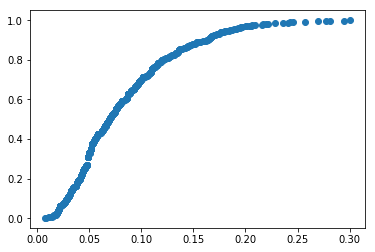

In [12]:
# Estimate the CDF F(x)

from statsmodels.distributions.empirical_distribution import ECDF

Fhat_public = ECDF(public.CDR3) 
plt.plot(public.CDR3, Fhat_public(public.CDR3), 'o')
plt.show()

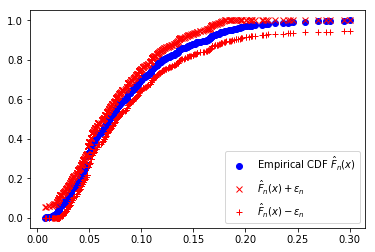

In [13]:
# Plot a 95% confidence envelope for F using the Dvorecky-Kiefer-Wolfowitz inequality:

alpha = 0.05
epsilon_n = np.sqrt(np.log(2/alpha)/(2*len(public.index)))

plt.plot(public.CDR3, Fhat_public(public.CDR3), 'bo', label = r'Empirical CDF $\hat{F}_n(x)$' )
plt.plot(public.CDR3, np.minimum(Fhat_public(public.CDR3) + epsilon_n,1), 'rx', label = r'$\hat{F}_n(x)+\varepsilon_n$')
plt.plot(public.CDR3, np.maximum(Fhat_public(public.CDR3) - epsilon_n,0), 'r+', label = r'$\hat{F}_n(x)-\varepsilon_n$')

plt.legend(loc = 4)

plt.show()

We can use $\hat{F}_n$ to estimate an approximate confidence interval for 1 - F(0.25):

$$\mathrm T(F) = 1 -F(0.25)\approx 1-\hat{F}_n(0.25)=0.00942$$

as:

In [17]:
p = 1- Fhat_public(0.25)
p

0.0094191522762950841

In [18]:
# Calculate zStat for 95% confidence interval 
zStat95 = -1 * scipy.stats.norm.ppf(0.025) 
zStat95

1.9599639845400545

In [19]:
Lower95 = round(p - zStat95 * np.sqrt(p*(1-p)/(len(public.CDR3))), 2)
Upper95 = round(p + zStat95 * np.sqrt(p*(1-p)/(len(public.CDR3))), 2)
Lower95, Upper95

(0.0, 0.02)

In [21]:
print("An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%)for public institutions is between " +
      "{} and {}".format(Lower95, Upper95) + "\n")

An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%)for public institutions is between 0.0 and 0.02



#### Private nonprofit institutions

In [22]:
# Estimate the cdf F(x) for private nonprofit institutions 

private_non = data[data.CONTROL == 2]

private_non.head()

,INSTNM,ICLEVEL,CONTROL,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
2,Amridge University,1,2,11082.0,0.3333,40100.0,0.100
10,Birmingham Southern College,1,2,19500.0,0.6270,45600.0,0.029
12,Concordia College Alabama,1,2,8250.0,0.1458,20600.0,0.310
16,Faulkner University,1,2,13750.0,0.2553,35900.0,0.095
23,Huntingdon College,1,2,16668.0,0.4327,36800.0,0.138


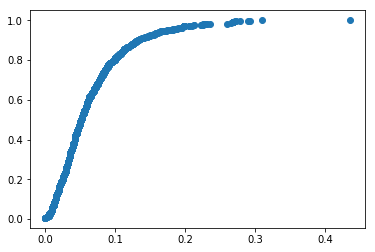

In [23]:
# Estimate the CDF F(x)

from statsmodels.distributions.empirical_distribution import ECDF

Fhat_private_non = ECDF(private_non.CDR3) 
plt.plot(private_non.CDR3, Fhat_private_non(private_non.CDR3), 'o')
plt.show()

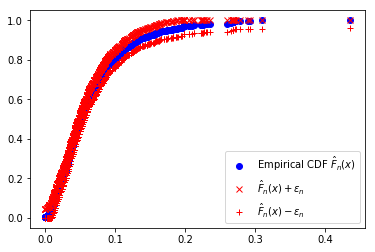

In [25]:
# Plot a 95% confidence envelope for F using the Dvorecky-Kiefer-Wolfowitz inequality:

n = len(private_non.index)
alpha = 0.05
epsilon_n = np.sqrt(np.log(2/alpha)/(2*n))

plt.plot(private_non.CDR3, Fhat_private_non(private_non.CDR3), 'bo', label = r'Empirical CDF $\hat{F}_n(x)$' )
plt.plot(private_non.CDR3, np.minimum(Fhat_private_non(private_non.CDR3) + epsilon_n,1), 'rx', label = r'$\hat{F}_n(x)+\varepsilon_n$')
plt.plot(private_non.CDR3, np.maximum(Fhat_private_non(private_non.CDR3) - epsilon_n,0), 'r+', label = r'$\hat{F}_n(x)-\varepsilon_n$')

plt.legend(loc = 4)

plt.show()

In [26]:
p = 1- Fhat_private_non(0.25)
p

0.017415215398716821

In [27]:
Lower95 = round(p - zStat95 * np.sqrt(p*(1-p)/n), 2)
Upper95 = round(p + zStat95 * np.sqrt(p*(1-p)/n), 2)
Lower95, Upper95

(0.01, 0.029999999999999999)

In [28]:
print("An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for private nonprofit institutions is between " +
      "{} and {}".format(Lower95, Upper95) + "\n")

An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for private nonprofit institutions is between 0.01 and 0.03



#### Private for-profit institutions

In [29]:
# Estimate the cdf F(x) for private for-profit institutions 

private = data[data.CONTROL == 3]

private.head()

,INSTNM,ICLEVEL,CONTROL,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
13,South University-Montgomery,1,3,9500.0,0.0792,30300.0,0.158
22,Herzing University-Birmingham,1,3,10858.0,0.4118,40300.0,0.117
66,Charter College,1,3,11783.0,0.4620,38300.0,0.148
78,Brookline College-Phoenix,1,3,9500.0,0.4200,21900.0,0.116
82,Southwest University of Visual Arts-Tucson,1,3,31000.0,0.9241,28500.0,0.147


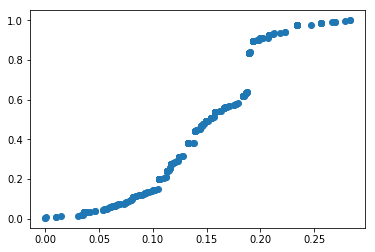

In [30]:
# Estimate the CDF F(x)

from statsmodels.distributions.empirical_distribution import ECDF

Fhat_private = ECDF(private.CDR3) 
plt.plot(private.CDR3, Fhat_private(private.CDR3), 'o')
plt.show()

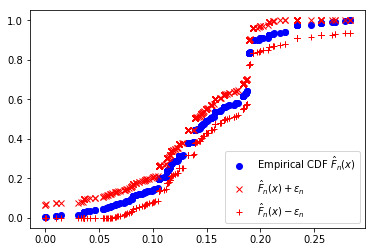

In [31]:
# Plot a 95% confidence envelope for F using the Dvorecky-Kiefer-Wolfowitz inequality:

n = len(private.index)
alpha = 0.05
epsilon_n = np.sqrt(np.log(2/alpha)/(2*n))

plt.plot(private.CDR3, Fhat_private(private.CDR3), 'bo', label = r'Empirical CDF $\hat{F}_n(x)$' )
plt.plot(private.CDR3, np.minimum(Fhat_private(private.CDR3) + epsilon_n,1), 'rx', label = r'$\hat{F}_n(x)+\varepsilon_n$')
plt.plot(private.CDR3, np.maximum(Fhat_private(private.CDR3) - epsilon_n,0), 'r+', label = r'$\hat{F}_n(x)-\varepsilon_n$')

plt.legend(loc = 4)

plt.show()

In [32]:
p = 1- Fhat_private(0.25)
p

0.023454157782515916

In [33]:
Lower95 = round(p - zStat95 * np.sqrt(p*(1-p)/n), 2)
Upper95 = round(p + zStat95 * np.sqrt(p*(1-p)/n), 2)
Lower95, Upper95

(0.01, 0.040000000000000001)

In [34]:
print("An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for private for-profit institutions is between " +
      "{} and {}".format(Lower95, Upper95) + "\n")

An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for private for-profit institutions is between 0.01 and 0.04



Based on the result, private for-profit institutions have the highest risk of surpassing 25% default rate on student loans, between 1% and 4%. 

This result aligns with past researches on student loan default rate that students from for-profit institutions have a greater risk of defaulting on their loans because many for-profit institutions are non-selective, and students of for-profit colleges are likely to be older, less likely to complete their degrees, have a higher risk of living in poverty, and have difficulty finding jobs after school. Since students enrolled in non-selective for-profit institutions are associated with these disadvantages, it is expected that students in these institutions have greater need to take out loans to pay for their education and lower post-graduation earnings. 


Compare to their peers in for-profit schools, the majority of students in private non-profit institutions come from relatively wealthier background, which decreases their chance of default. Furthermore, students who hold a degree from selective private non-profit institutions tend to experience better labor market outcomes after leaving school, and earn higher salaries to pay back their loans. These advantages reduce the chance of students from private non-profit institutions to go into default and the smaller risk for surpassing 25% default rate.

Lower tuition fees at public institutions could account for the institutions having the lowest risk of having cohort default rate over 25%. 

### Estimate cumulative distribution of cohort default rate for all institutions

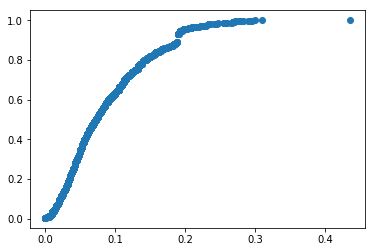

In [35]:
from statsmodels.distributions.empirical_distribution import ECDF

Fhat = ECDF(data.CDR3) 
plt.plot(data.CDR3, Fhat(data.CDR3), 'o')
plt.show()

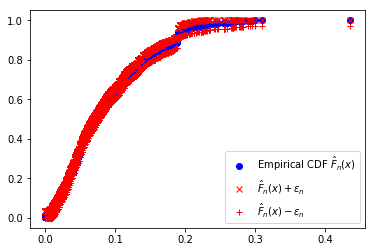

In [36]:
n = len(data.index)
alpha = 0.05
epsilon_n = np.sqrt(np.log(2/alpha)/(2*n))

plt.plot(data.CDR3, Fhat(data.CDR3), 'bo', label = r'Empirical CDF $\hat{F}_n(x)$' )
plt.plot(data.CDR3, np.minimum(Fhat(data.CDR3) + epsilon_n,1), 'rx', label = r'$\hat{F}_n(x)+\varepsilon_n$')
plt.plot(data.CDR3, np.maximum(Fhat(data.CDR3) - epsilon_n,0), 'r+', label = r'$\hat{F}_n(x)-\varepsilon_n$')

plt.legend(loc = 4)

plt.show()

In [37]:
p = 1- Fhat(0.25)
p

0.016385980883022344

In [38]:
Lower95 = round(p - zStat95 * np.sqrt(p*(1-p)/n), 2)
Upper95 = round(p + zStat95 * np.sqrt(p*(1-p)/n), 2)
Lower95, Upper95

(0.01, 0.02)

In [39]:
print("An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for all institutions is between " +
      "{} and {}".format(Lower95, Upper95) + "\n")

An approximate 95% confidence interval for 1 - F(0.25) (Probability of cohort default rate greater than 25%) for all institutions is between 0.01 and 0.02



### Is distribution of cohort default rate normal? 

#### Sampling Distribution of the Skewness 

In [41]:
# plug-in estimate 
skew = data['CDR3'].skew()

skew

0.89405116036895915

In [42]:
#Use nonparametric bootstrap to get the se for skew and 95 percent confidence interval 

B = 10000 #Number of bootstrap samples
N = len(data.index) 

theta_boot = []

for i in range(B):
    resampleObs = np.random.choice(data['CDR3'], size=N, replace=True)
    resampledSkew = pd.Series(resampleObs).skew()
    theta_boot.append(resampledSkew)

In [43]:
# Bootstrap standard error is 
theta_boot = np.array(theta_boot)
std = theta_boot.std()

In [44]:
LowerEst = skew - zStat95 * std
UpperEst = skew + zStat95 * std

print("The normal 95% confidence interval for the skew is given by, " +
      "Lower: {} and Upper: {}.".format(round(LowerEst,2), round(UpperEst,2)))

The normal 95% confidence interval for the skew is given by, Lower: 0.77 and Upper: 1.02.


In [46]:
# Percentile interval
print("The percentile 95% confidence interval for the skew is",[np.percentile(theta_boot,0.025, interpolation='higher'), np.percentile(theta_boot, 0.975)] )


The percentile 95% confidence interval for the skew is [0.70833157038085259, 0.75993084699623592]


#### Q-Q Plot

In [47]:
arr = data['CDR3'].values
arr

array([ 0.165,  0.053,  0.1  , ...,  0.106,  0.1  ,  0.222])

In [48]:
# Calculate MLE 

mu = arr.mean()

std = arr.std()

mu, std

(0.089486572598998643, 0.062396433459471851)

In [49]:
import pylab

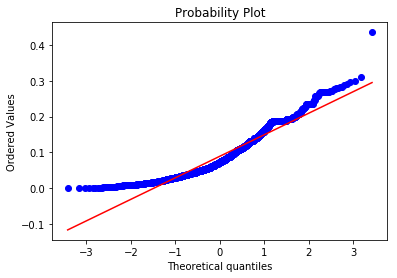

In [51]:
scipy.stats.probplot(arr, dist="norm", plot=pylab)
pylab.show()

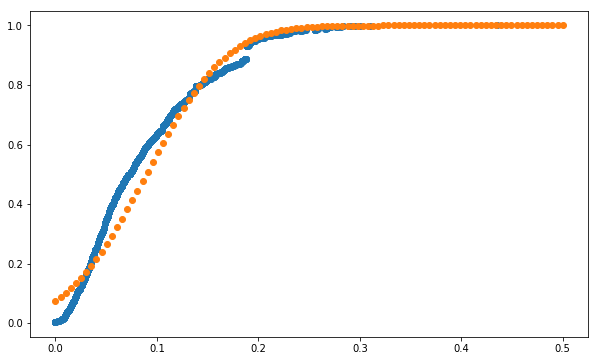

In [53]:
plt.figure(figsize=(10, 6))
x = np.linspace(0,0.5,num = 100)
line1, = plt.plot(data.CDR3, Fhat(data.CDR3), 'o')
line2 = plt.plot(x, scipy.stats.norm.cdf(x,mu,std), 'o')

plt.show()

By the above, it is evident that the distribution of cohort default rate has a slight positive skew. This corresponds to the fact that institutions are incentivized to lower their cohort default rate. Nevertheless, in the Q-Q plot, we see that the main body of the distribution seems to fall around the straight line, despite the outlier on the upper right. Therefore, we can assume that the distribution of cohort default rate is approximately normal. 

### Estimate 95% confidence interval for mean cohort default rate using bootstrap and pivot

#### Pivot

In [59]:
# Since we assumed the distribution is normal, we can use the pivot where population standard deviation is unknown

mu = data['CDR3'].mean()
mu

0.08948657259899878

In [60]:
std_mu = data['CDR3'].std()
std_mu

0.06241063868070522

In [61]:
tStat95 = -1 * scipy.stats.t.ppf(0.025,len(data.index)-1) 
tStat95

1.9610448392992761

In [69]:
LowerEst = mu - tStat95 * std_mu/np.sqrt(len(data.index))
UpperEst = mu + tStat95 * std_mu/np.sqrt(len(data.index))

print("The Pivotal 95% confidence interval is given by, " +
      "Lower: {} and Upper: {}.".format(round(LowerEst,4), round(UpperEst,4)))

The Pivotal 95% confidence interval is given by, Lower: 0.0869 and Upper: 0.0921.


#### Bootstrap

In [63]:
# (a) Use the bootstrap to get the se and 95 percent confidence interval 

B = 10000 #Number of bootstrap samples
N = len(data.index) 

mu_boot = []

for i in range(B):
    resampleObs_mu = np.random.choice(data['CDR3'], size=N, replace=True)
    resampledMean = pd.Series(resampleObs_mu).mean()
    mu_boot.append(resampledMean)

In [64]:
vBoot = np.var(mu_boot)
vBoot

1.749788066118194e-06

In [65]:
seBoot = np.sqrt(vBoot)
seBoot

0.0013227955496289644

In [68]:
# set z-statistic for 95% bound

LowerEst = mu - zStat95 * seBoot
UpperEst = mu + zStat95 * seBoot

print("The Normal 95% confidence interval is given by, " +
      "Lower: {} and Upper: {}.".format(round(LowerEst,4), round(UpperEst,4)))

The Normal 95% confidence interval is given by, Lower: 0.0869 and Upper: 0.0921.


The two methods show agreement because the sample is large and because the distribution of the cohort default rate is approximately normal

### Are there significance differences in mean cohort default rate between different types of institution?

Methods: Wald Test & Bonferroni Method

In [70]:
# Descriptive statistics by group 

data['CDR3'].groupby(data['CONTROL']).describe()


,count,mean,std,min,25%,50%,75%,max
CONTROL,,,,,,,,
1,637.0,0.083669,0.052278,0.008,0.046,0.070,0.110,0.300
2,1091.0,0.066429,0.054048,0.000,0.030,0.052,0.086,0.435
3,469.0,0.151026,0.051756,0.000,0.116,0.154,0.189,0.283


In [71]:
bonferroni_critical = 0.05/3 

#### Public vs. Private nonprofit

Let $\mu_1$ be the population mean of cohort default rate for public ($X_1,...,X_{637}$) and $\mu_2$ be the population mean for private nonprofit ($Y_1,...,Y_{1091}$) respectively. 
<br>If $\delta = \mu_1 - \mu_2$, then we consider the test 
$$ H_0 : \delta = 0, \qquad vs \qquad H_1: \delta \ne 0$$ 
Note that the sampling distribution of a difference in sample means from independent samples is approximately normal <br> 
The non-parametric estimate of $\delta$ is $\hat{\delta} = \bar{X} - \bar{Y}$ with estimated standard error 
$$ \hat{se} = \sqrt{\frac{{s_1}^2}{637} + \frac{{s_2}^2}{1091}} $$
where ${s_1}^2$ and ${s_2}^2$ are the sample variances. 

The Wald statistics is given by 
$$ W = \frac {\hat{\delta}}{\hat{se}} = \frac {\bar{X} - \bar{Y}}{\sqrt{\frac{{s_1}^2}{637} + \frac{{s_2}^2}{1091}}} $$
and the size $\alpha$ Wald test rejects $H_0$ when $\vert W \vert$ > $z_{\alpha/2}$

In [72]:
xbar = public['CDR3'].mean()
ybar = private_non['CDR3'].mean()
xbar, ybar

(0.08366875981161695, 0.06642896425297892)

In [73]:
hat_var1 = ((public['CDR3'].std())**2)/637
hat_var2 = ((private_non['CDR3'].std())**2)/1091
hat_var1, hat_var2

(4.290327864301631e-06, 2.6775681301807054e-06)

In [76]:
delta = xbar - ybar
alpha = 0.05 
hat_se = np.sqrt(hat_var1 + hat_var2) 

W = delta/hat_se 

z = scipy.stats.norm.ppf(1-alpha/2)

print("The test statistic: {}, The critical value: {}".format(np.abs(W),z))

pval = 2*scipy.stats.norm.cdf(-np.abs(W))
print("The p-value is {}".format(pval))

if (np.abs(W) > z):
    print("The null hypothesis is rejected at size {}.".format(alpha))
elif (pval < bonferroni_critical):
    print("The null hypothesis is rejected at size {} by the Bonferroni method.".format(alpha))
else:
    print("Failed to reject the null hypothesis at size {}.".format(alpha))
    


The test statistic: 6.531024027985901, The critical value: 1.959963984540054
The p-value is 6.532151722154075e-11
The null hypothesis is rejected at size 0.05.


In [77]:
# Find confidence interval 

lower = delta - (hat_se*z)
upper = delta + (hat_se*z)

print("A 95% confidence interval for the difference is ({},{})".format(lower,upper))

A 95% confidence interval for the difference is (0.012066123213998928,0.022413467903277126)


#### Public vs. private for-profit

Let $\mu_1$ be the population mean of cohort default rate for public ($X_1,...,X_{637}$) and $\mu_2$ be the population mean for private for-profit ($Y_1,...,Y_{469}$) respectively. 
<br>If $\delta = \mu_1 - \mu_2$, then we consider the test 
$$ H_0 : \delta = 0, \qquad vs \qquad H_1: \delta \ne 0$$ 
Note that the sampling distribution of a difference in sample means from independent samples is approximately normal <br> 
The non-parametric estimate of $\delta$ is $\hat{\delta} = \bar{X} - \bar{Y}$ with estimated standard error 
$$ \hat{se} = \sqrt{\frac{{s_1}^2}{637} + \frac{{s_2}^2}{469}} $$
where ${s_1}^2$ and ${s_2}^2$ are the sample variances. 

The Wald statistics is given by 
$$ W = \frac {\hat{\delta}}{\hat{se}} = \frac {\bar{X} - \bar{Y}}{\sqrt{\frac{{s_1}^2}{637} + \frac{{s_2}^2}{469}}} $$
and the size $\alpha$ Wald test rejects $H_0$ when $\vert W \vert$ > $z_{\alpha/2}$

In [78]:
xbar = public['CDR3'].mean()
ybar = private['CDR3'].mean()
xbar, ybar

(0.08366875981161695, 0.1510255863539445)

In [79]:
hat_var1 = ((public['CDR3'].std())**2)/637
hat_var2 = ((private['CDR3'].std())**2)/469
hat_var1, hat_var2

(4.290327864301631e-06, 5.711395827473222e-06)

In [80]:
delta = xbar - ybar
alpha = 0.05 
hat_se = np.sqrt(hat_var1 + hat_var2) 

W = delta/hat_se 

z = scipy.stats.norm.ppf(1-alpha/2)

print("The test statistic: {}, The critical value: {}".format(np.abs(W),z))

pval = 2*scipy.stats.norm.cdf(-np.abs(W))
print("The p-value is {}".format(pval))

if (np.abs(W) > z):
    print("The null hypothesis is rejected at size {}.".format(alpha))
elif (pval < bonferroni_critical):
    print("The null hypothesis is rejected at size {} by the Bonferroni method.".format(alpha))
else:
    print("Failed to reject the null hypothesis at size {}.".format(alpha))
    


The test statistic: 21.298263280494762, The critical value: 1.959963984540054
The p-value is 1.1780853580134587e-100
The null hypothesis is rejected at size 0.05.


In [81]:
# Find confidence interval 

lower = delta - (hat_se*z)
upper = delta + (hat_se*z)

print("A 95% confidence interval for the difference is ({},{})".format(lower,upper))

A 95% confidence interval for the difference is (-0.07355531101015628,-0.06115834207449883)


#### Private nonprofit vs. private for-profit

Let $\mu_1$ be the population mean of CDR3 for private non-profit ($X_1,...,X_{1091}$) and $\mu_2$ be the population mean for private for-profit ($Y_1,...,Y_{469}$) respectively. 
<br>If $\delta = \mu_1 - \mu_2$, then we consider the test 
$$ H_0 : \delta = 0, \qquad vs \qquad H_1: \delta \ne 0$$ 
Note that the sampling distribution of a difference in sample means from independent samples is approximately normal <br> 
The non-parametric estimate of $\delta$ is $\hat{\delta} = \bar{X} - \bar{Y}$ with estimated standard error 
$$ \hat{se} = \sqrt{\frac{{s_1}^2}{1091} + \frac{{s_2}^2}{469}} $$
where ${s_1}^2$ and ${s_2}^2$ are the sample variances. 

The Wald statistics is given by 
$$ W = \frac {\hat{\delta}}{\hat{se}} = \frac {\bar{X} - \bar{Y}}{\sqrt{\frac{{s_1}^2}{1091} + \frac{{s_2}^2}{469}}} $$
and the size $\alpha$ Wald test rejects $H_0$ when $\vert W \vert$ > $z_{\alpha/2}$

In [82]:
xbar = private_non['CDR3'].mean()
ybar = private['CDR3'].mean()
xbar, ybar

(0.06642896425297892, 0.1510255863539445)

In [85]:
hat_var1 = ((private_non['CDR3'].std())**2)/1091
hat_var2 = ((private['CDR3'].std())**2)/469
hat_var1, hat_var2

(2.6775681301807054e-06, 5.711395827473222e-06)

In [1]:
delta = xbar - ybar
alpha = 0.05 
hat_se = np.sqrt(hat_var1 + hat_var2) 

W = delta/hat_se 

z = scipy.stats.norm.ppf(1-alpha/2)

print("The test statistic: {}, The critical value: {}".format(np.abs(W),z))

pval = 2*scipy.stats.norm.cdf(-np.abs(W))
print("The p-value is {}".format(pval))

if (np.abs(W) > z):
    print("The null hypothesis is rejected at size {}.".format(alpha))
elif (pval < bonferroni_critical):
    print("The null hypothesis is rejected at size {} by the Bonferroni method.".format(alpha))
else:
    print("Failed to reject the null hypothesis at size {}.".format(alpha))

NameError: name 'xbar' is not defined

In [87]:
# Find confidence interval 

lower = delta - (hat_se*z)
upper = delta + (hat_se*z)

print("A 95% confidence interval for the difference is ({},{})".format(lower,upper))

A 95% confidence interval for the difference is (-0.0902734046044278,-0.07891983959750336)


There is convincing evidence that the mean cohort default rate is significantly different among all of the different types of institutions.

### Building a Model

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


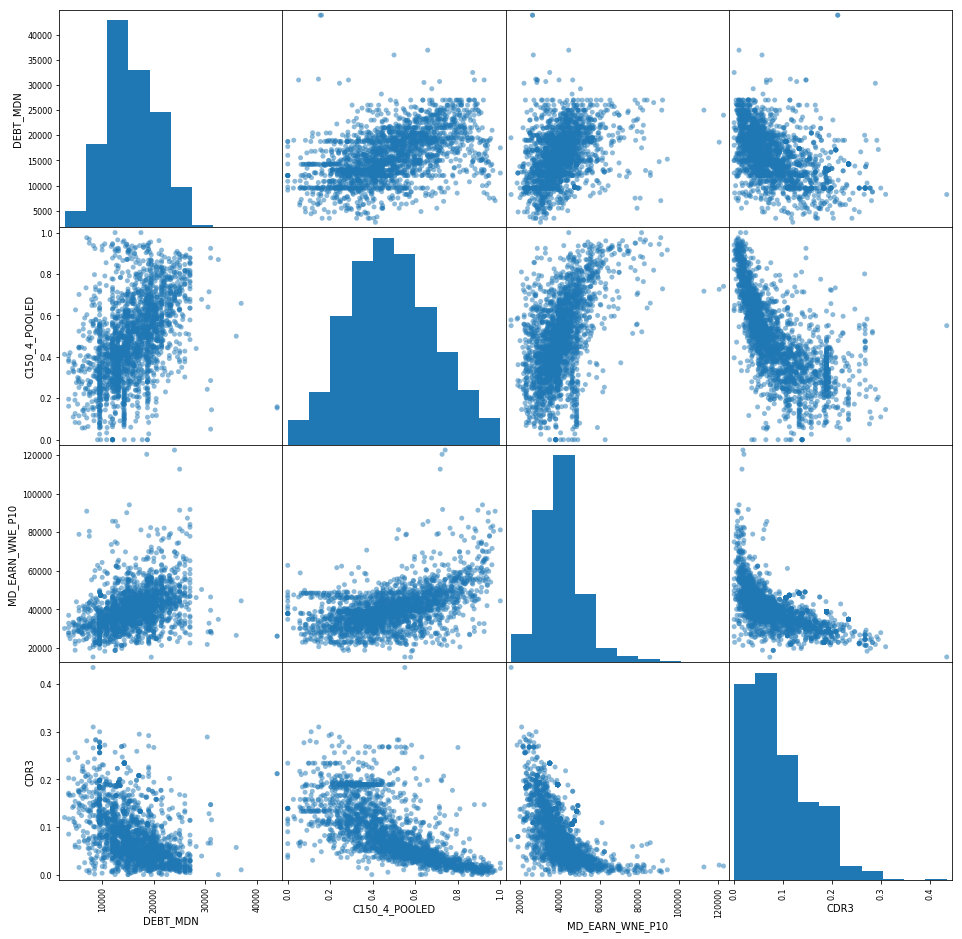

In [88]:
### Visualize the data 
from pandas.tools.plotting import scatter_matrix
scatter_matrix (data, s=100, figsize=(16, 16));

#### Checking for multi-collinearity

We can also check if any variables appear to be highly-correlated. 

In [89]:
data.corr()

,DEBT_MDN,C150_4_POOLED,MD_EARN_WNE_P10,CDR3
DEBT_MDN,1.000000,0.476029,0.372138,-0.479162
C150_4_POOLED,0.476029,1.000000,0.508210,-0.661117
MD_EARN_WNE_P10,0.372138,0.508210,1.000000,-0.589684
CDR3,-0.479162,-0.661117,-0.589684,1.000000


In [90]:
import seaborn as sns
sns.set(color_codes=True)

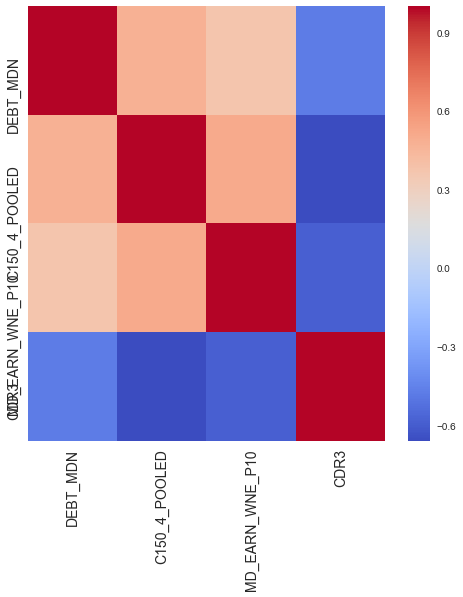

In [91]:
plt.figure(figsize=(8,8))
# calculate the correlation matrix
corr = data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='coolwarm');
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

We are interested in the relationship between cohort default rate and completion rate as there seems to be a moderate association.

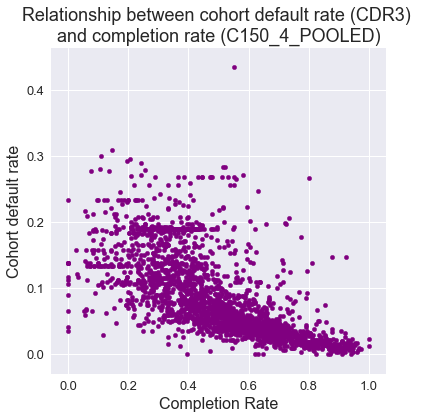

In [92]:
plt.figure(figsize=(6,6))
plt.scatter(data.C150_4_POOLED, data.CDR3, s=20, c='purple')


plt.title('Relationship between cohort default rate (CDR3) \nand completion rate (C150_4_POOLED)', fontsize = 18)
plt.xlabel('Completion Rate', fontsize = 16)
plt.ylabel('Cohort default rate', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13);

As above, the relationship looks interesting. Intuitively it's showing that higher student completion rate leads to lower student loan default rate. This makes sense as students who earn degrees can have better chances of finding a job and repay their loans. 

In [93]:
#Let's see how well a simple linear model for cohort default rate as a function of student completion rate works

y = data.CDR3
X = data.C150_4_POOLED


X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()   

In [94]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CDR3   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1704.
Date:                Tue, 08 May 2018   Prob (F-statistic):          3.39e-276
Time:                        23:18:30   Log-Likelihood:                 3608.8
No. Observations:                2197   AIC:                            -7214.
Df Residuals:                    2195   BIC:                            -7202.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1885      0.003     72.557      0.000       0.183       0.194
C150_4_POOLED    -0.2039      0.005    -41.283      0.000      -0.214      -0.194
==============================================================================
Omnibus:                      574.397   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1838.652
Skew:                           1.302   Prob(JB):                         0.00
Kurtosis:                       6.647   Cond. No.                         6.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

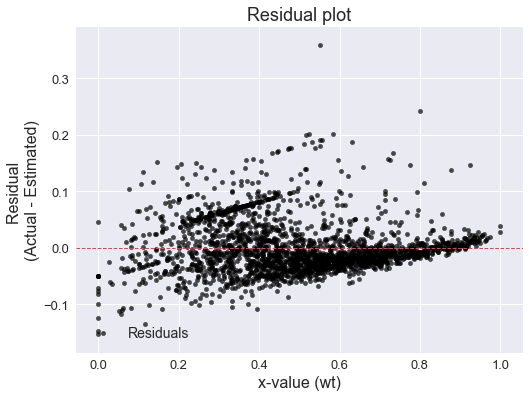

In [95]:
### Let's check the residual plot

xResid = data.C150_4_POOLED

plt.figure(figsize=(8,6))
plt.scatter(xResid, results.resid, c='black', s=20, alpha=0.7, label='Residuals')
plt.axhline(y=0, ls='--', c='r', lw=1)
plt.legend(fontsize=14)
plt.title('Residual plot', fontsize = 18)
plt.xlabel('x-value (wt)', fontsize = 16)
plt.ylabel('Residual \n(Actual - Estimated)', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(loc='lower left', fontsize = 14);

The slope parameter is statistically significant. However, the model doesn't seem to be very effective as the residual is not very scattered. This may be because the relationship between completion rate and cohort default rate seems to be curvilinear.

#### Multiple Regression

We want to use the remaining variables we have to build a better model 

In [96]:
multiData = data[['CDR3','C150_4_POOLED','MD_EARN_WNE_P10','DEBT_MDN']]

multiData.head()

,CDR3,C150_4_POOLED,MD_EARN_WNE_P10,DEBT_MDN
0,0.165,0.3303,29900.0,14600.0
1,0.053,0.5504,40200.0,14250.0
2,0.100,0.3333,40100.0,11082.0
3,0.052,0.4776,45600.0,15000.0
4,0.167,0.2663,26700.0,15274.0


In [97]:
# Perform log transformations for earning and debt 

multiData['logEARN'] = np.log(multiData['MD_EARN_WNE_P10'])

multiData['logDEBT'] = np.log(multiData['DEBT_MDN'])

multiData.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CDR3,C150_4_POOLED,MD_EARN_WNE_P10,DEBT_MDN,logEARN,logDEBT
0,0.165,0.3303,29900.0,14600.0,10.305614,9.588777
1,0.053,0.5504,40200.0,14250.0,10.601622,9.564512
2,0.100,0.3333,40100.0,11082.0,10.599132,9.313077
3,0.052,0.4776,45600.0,15000.0,10.727663,9.615805
4,0.167,0.2663,26700.0,15274.0,10.192419,9.633907


In [98]:
lmMulti = smf.ols('CDR3~C150_4_POOLED+logDEBT+logEARN',data=multiData).fit()

In [99]:
lmMulti.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CDR3   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     981.6
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        23:25:38   Log-Likelihood:                 3912.8
No. Observations:                2197   AIC:                            -7818.
Df Residuals:                    2193   BIC:                            -7795.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3408      0.044     30.650      0.000       1.255       1.427
C150_4_POOLED    -0.1281      0.005    -24.485      0.000      -0.138      -0.118
logDEBT          -0.0264      0.003     -9.078      0.000      -0.032      -0.021
logEARN          -0.0885      0.004    -22.229      0.000      -0.096      -0.081
==============================================================================
Omnibus:                      257.080   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.593
Skew:                           0.754   Prob(JB):                    1.61e-105
Kurtosis:                       4.732   Cond. No.                         724.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

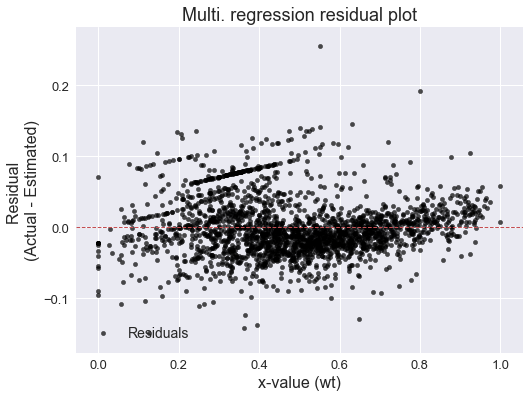

In [100]:
xResid = multiData['C150_4_POOLED'] #Plot against one of the x-variables to assess residuals

plt.figure(figsize=(8,6))
plt.scatter(xResid, lmMulti.resid, c='black', s=20, alpha=0.7, label='Residuals')
plt.axhline(y=0, ls='--', c='r', lw=1)
plt.legend(fontsize=14)
plt.title('Multi. regression residual plot', fontsize = 18)
plt.xlabel('x-value (wt)', fontsize = 16)
plt.ylabel('Residual \n(Actual - Estimated)', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(loc='lower left', fontsize = 14);

In [101]:
## Check multicollinearity using VIF 

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = lmMulti.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif

[2525.5076691635859,
 1.4787199458191198,
 1.3328439097476794,
 1.3820322580225139]

Here, the Rsquared is higher and the residual plot looks more normal. Also, VIF is within the acceptable range and the parameters are significant. However, the association between debt and cohort default rate is a negative one (higher debt is correlated with lower cohort default rate) as it is also in the correlation matrix above. This doesn't seem to make sense intuitively and for further exploration, we could investigate why this may be occurring and perhaps replace this covariate with another better correlated one. 